In [38]:
import json
import pandas as pd
import random
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import sys
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
from collections import Counter
from scipy.stats.mstats import winsorize
import re

In [39]:
def read_file(filepath):
    data = []
    with open(filepath, 'r', errors='replace') as file:
        for line in file:
            try:
                json_obj = json.loads(line)
                data.append(json_obj)
            except json.JSONDecodeError:
                pass
    return data


In [40]:
review_data = pd.DataFrame(read_file('yelp_academic_dataset_review.json'))
business_data = pd.DataFrame(read_file('yelp_academic_dataset_business.json'))

In [41]:
# read the labeld data
label_df=pd.read_csv('C:/Users/yun13369/Downloads/540/df_test_labeled.csv')

In [42]:
label_df.head()

,review_id,text,food_quality,environment,service,convenience,cost_effectiveness
0,ZRRSVXNw3jR66lY_Iz9DDQ,Just left this restaurant......BEWARE....order...,-1,0,-1,0,0
1,9nGyZKtYxkR6zi6laHtEdg,Updating my previous review of this location.....,1,0,-1,0,0
2,urPoX4vS6p5a7yDrMkGIeQ,Pretty outdoor mall right in the heart of Stat...,0,0,0,0,0
3,0IaehZ_ujUHyfAoKul8-aw,"Yeah, I was not impressed by this place at all...",0,1,1,0,0
4,m-23Loxm1O0Vd5HLHs7i3g,Some of the best pizza we've had. Awesome ing...,1,0,0,0,0


In [43]:
label_df.shape

(1000000, 7)

In [44]:
print("Review Data Info:")
print(review_data.info())

# Display basic information about the 'business_data'
print("\nBusiness Data Info:")
print(business_data.info())

Review Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   review_id    object 
 1   user_id      object 
 2   business_id  object 
 3   stars        float64
 4   useful       int64  
 5   funny        int64  
 6   cool         int64  
 7   text         object 
 8   date         object 
dtypes: float64(1), int64(3), object(5)
memory usage: 480.0+ MB
None

Business Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       150346 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150346 non-null  object 
 6   latitude      150346 non-n

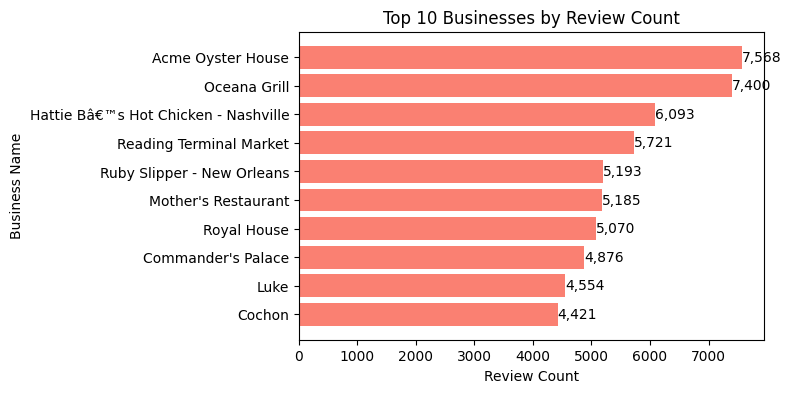

In [45]:
top_businesses = business_data.nlargest(10, 'review_count')[::-1]

# Plot the top 10 businesses
plt.figure(figsize=(6, 4))
bars = plt.barh(top_businesses['name'], top_businesses['review_count'], color='salmon')
plt.title('Top 10 Businesses by Review Count')
plt.xlabel('Review Count')
plt.ylabel('Business Name')

# Add business names on the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():,.0f}', ha='left', va='center')

plt.show()

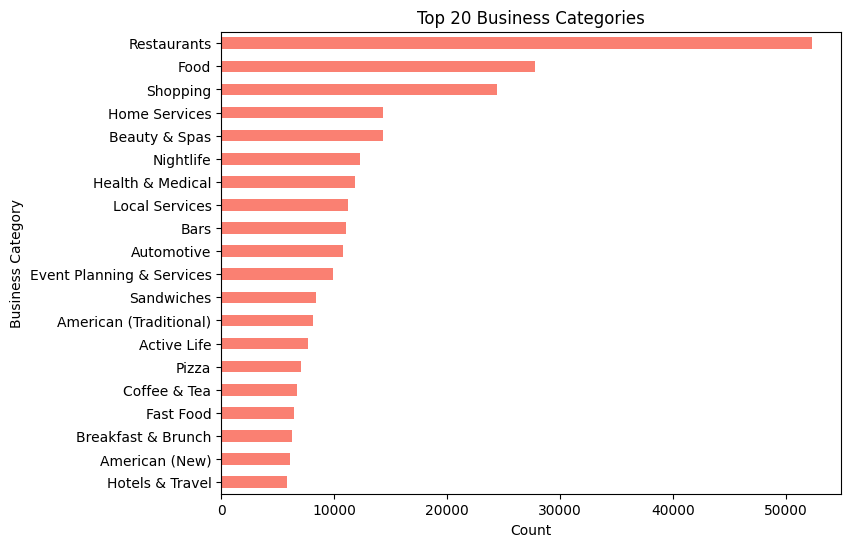

In [46]:
# Split categories and count unique values
categories_split = business_data['categories'].str.split(', ', expand=True).stack()
# Count and sort the values
category_counts = categories_split.value_counts()
plt.figure(figsize=(8, 6))
category_counts.head(20)[::-1].plot(kind='barh', color='salmon')  # Reverse the order
plt.title('Top 20 Business Categories')
plt.xlabel('Count')
plt.ylabel('Business Category')
plt.show()

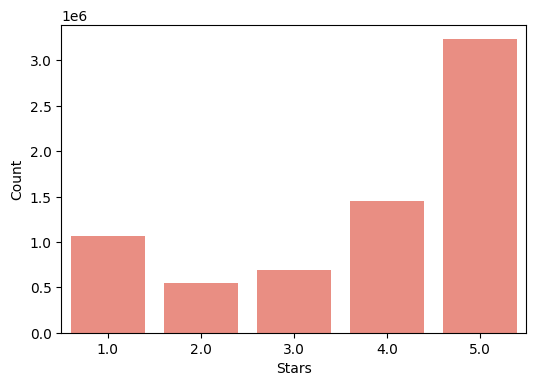

In [47]:
plt.figure(figsize=(6, 4))
sns.countplot(x='stars', data=review_data, color='salmon')
plt.xlabel('Stars')
plt.ylabel('Count')
plt.show()

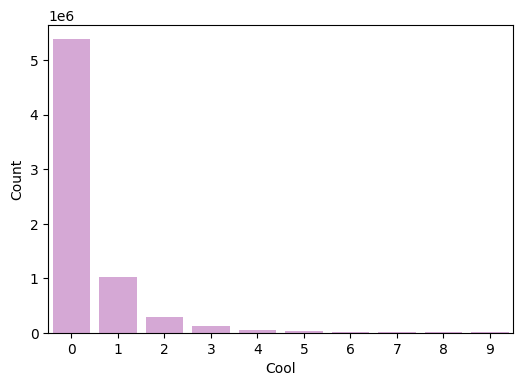

In [48]:
cool_column = review_data['cool']
cool_column = cool_column[(cool_column < 10) & (cool_column > -1)]

plt.figure(figsize=(6, 4))
sns.countplot(x=cool_column, color='plum')
plt.xlabel('Cool')
plt.ylabel('Count')
plt.show()

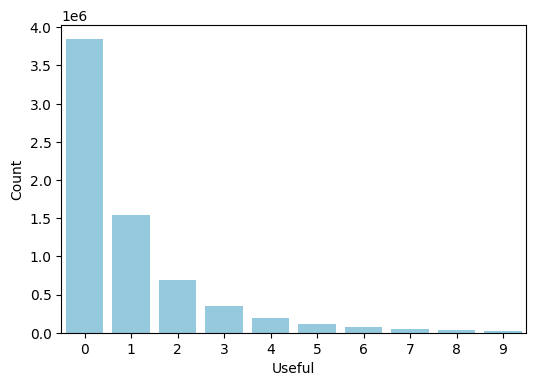

In [49]:
useful_column = review_data['useful']
useful_column = useful_column[(useful_column < 10) & (useful_column > -1)]

plt.figure(figsize=(6, 4))
sns.countplot(x=useful_column, color='skyblue')
plt.xlabel('Useful')
plt.ylabel('Count')
plt.show()

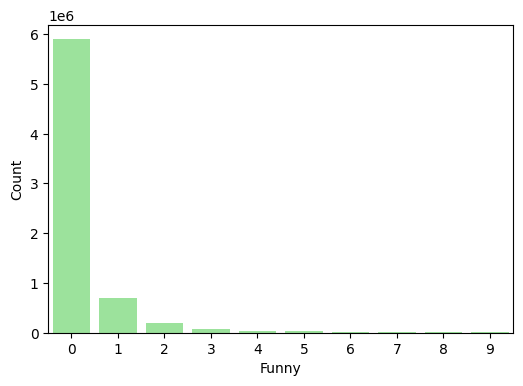

In [50]:
funny_column = review_data['funny']
funny_column = funny_column[(funny_column < 10) & (funny_column > -1)]

plt.figure(figsize=(6, 4))
sns.countplot(x=funny_column, color='lightgreen')
plt.xlabel('Funny')
plt.ylabel('Count')
plt.show()

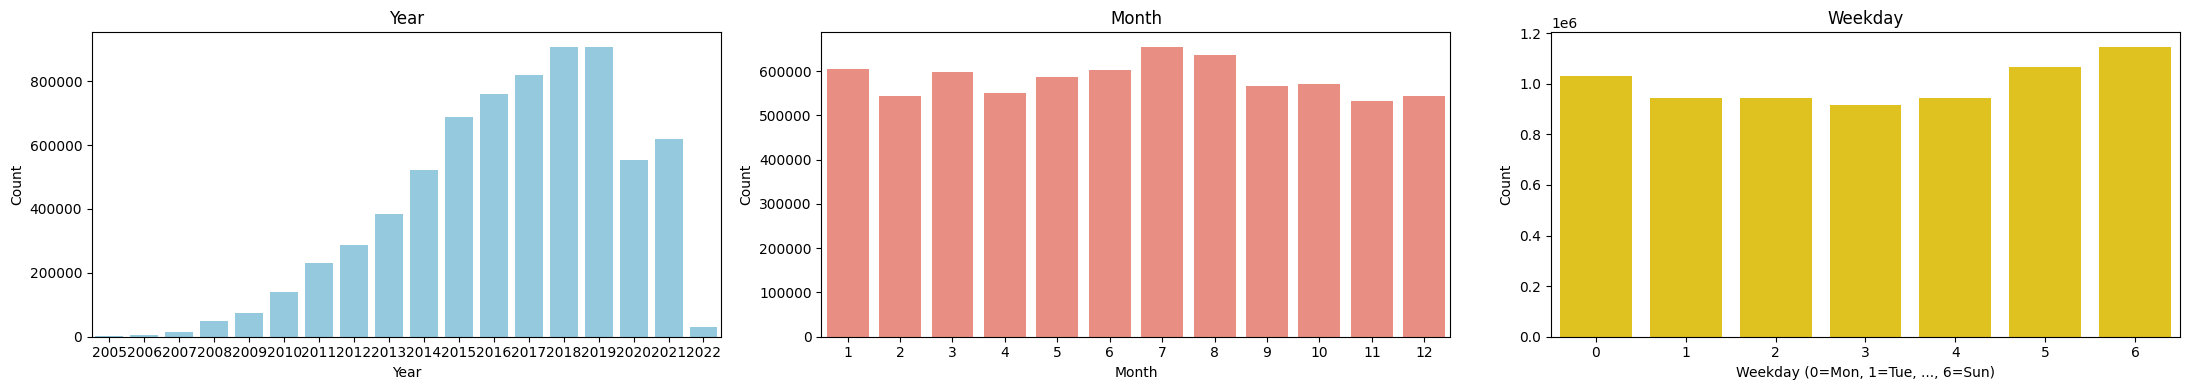

In [51]:
review_data['date'] = pd.to_datetime(review_data['date'])

# Extract year, month, day, and weekday for analysis
review_data['year'] = review_data['date'].dt.year
review_data['month'] = review_data['date'].dt.month
review_data['day'] = review_data['date'].dt.day
review_data['weekday'] = review_data['date'].dt.weekday  # Monday is 0 and Sunday is 6

# Plot the distribution of reviews over the years, months, days of the month, and weekdays in a single row
fig, axes = plt.subplots(1, 3, figsize=(22, 4))

# Plot for the distribution of reviews over the years
sns.countplot(x='year', data=review_data, color='skyblue', ax=axes[0])
axes[0].set_title('Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Count')

# Plot for the distribution of reviews over months
sns.countplot(x='month', data=review_data, color='salmon', ax=axes[1])
axes[1].set_title('Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Count')

# Plot for the weekdays
sns.countplot(x='weekday', data=review_data, color='gold', ax=axes[2])
axes[2].set_title('Weekday')
axes[2].set_xlabel('Weekday (0=Mon, 1=Tue, ..., 6=Sun)')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [68]:
df_full = review_data.join(business_data.set_index('business_id'), on='business_id', rsuffix='_business')
filtered_df = df_full[df_full['categories'].str.contains("Restaurant", na=False)]
labeled_id=pd.read_excel('labeled_review_id.xlsx')
filtered_df = filtered_df[~filtered_df['review_id'].isin(labeled_id['review_id'])]

# join filtered_df with label data
filtered_df=pd.merge(filtered_df,label_df,left_on='review_id',right_on='review_id',how='left')

filtered_df = filtered_df[['date','stars','useful', 'funny', 'cool', 'text_x','food_quality','environment','service','convenience','cost_effectiveness', 'categories']]
filtered_df = filtered_df.rename(columns={'text_x':'text'})

sample_size = 1000000
filtered_df = filtered_df.sample(n=sample_size, random_state=42)
filtered_df = filtered_df.dropna()

In [69]:
numerical_columns = ['useful', 'funny', 'cool']

# Apply winsorization to each numerical column
for column in numerical_columns:
    # Winsorize the column, replacing extreme values with values within the specified limits
    filtered_df[column] = winsorize(filtered_df[column], limits=[0.05, 0.05])

In [70]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 987565 entries, 3611164 to 3011421
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date                987565 non-null  datetime64[ns]
 1   stars               987565 non-null  float64       
 2   useful              987565 non-null  int64         
 3   funny               987565 non-null  int64         
 4   cool                987565 non-null  int64         
 5   text                987565 non-null  object        
 6   food_quality        987565 non-null  float64       
 7   environment         987565 non-null  float64       
 8   service             987565 non-null  float64       
 9   convenience         987565 non-null  float64       
 10  cost_effectiveness  987565 non-null  float64       
 11  categories          987565 non-null  object        
dtypes: datetime64[ns](1), float64(6), int64(3), object(2)
memory usage: 97.9+ MB


In [71]:
filtered_df.head(20)

,date,stars,useful,funny,cool,text,food_quality,environment,service,convenience,cost_effectiveness,categories
3611164,2017-02-20 22:03:33,1.0,0,0,0,Just left this restaurant......BEWARE....order...,-1.0,0.0,-1.0,0.0,0.0,"Restaurants, Steakhouses"
2181081,2018-02-14 18:51:51,1.0,1,0,0,Updating my previous review of this location.....,1.0,0.0,-1.0,0.0,0.0,"Restaurants, Sandwiches, Salad, Soup"
954153,2015-11-30 23:56:07,4.0,1,1,1,Pretty outdoor mall right in the heart of Stat...,0.0,0.0,0.0,0.0,0.0,"American (Traditional), Restaurants, Shopping ..."
3769474,2009-05-15 00:06:58,2.0,2,1,2,"Yeah, I was not impressed by this place at all...",0.0,1.0,1.0,0.0,0.0,"Bars, American (New), Restaurants, Nightlife, ..."
2085325,2011-05-17 01:50:34,5.0,1,0,0,Some of the best pizza we've had. Awesome ing...,1.0,0.0,0.0,0.0,0.0,"Pizza, Restaurants, Italian"
770304,2019-03-02 19:46:10,1.0,0,0,0,literally a joke in regards to service. the pi...,-1.0,0.0,-1.0,0.0,0.0,"Restaurants, Wraps, Food, Pizza, Salad"
3817864,2017-05-15 15:43:06,3.0,0,0,0,Spent a few hours here to wrap up our Mother's...,-1.0,0.0,-1.0,0.0,0.0,"Bars, Nightlife, Tapas/Small Plates, Tapas Bar..."
4240803,2015-07-04 03:22:19,4.0,4,1,2,"For my Combo Plate, I chose the Chicken Katsu ...",1.0,0.0,1.0,0.0,0.0,"Caterers, Hawaiian, Restaurants, Burgers, Barb..."
707924,2009-02-17 19:50:44,3.0,4,2,2,It was good. AND SO MUCH FUN!\nI took the bf f...,-1.0,0.0,0.0,0.0,0.0,"Seafood, Steakhouses, Brazilian, Restaurants"
4423096,2016-03-15 17:48:16,2.0,0,0,0,"Pretty fair to say, based on past reviews that...",1.0,0.0,1.0,0.0,0.0,"Japanese, Restaurants"


In [72]:
translator = str.maketrans('', '', string.punctuation)

def preprocess_text(text):

    text = text.translate(translator)
    text = text.lower()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    return ' '.join(words)

In [73]:
filtered_df['cleaned_text'] = filtered_df['text'].apply(preprocess_text)

In [74]:
unwanted_words = ['food', 'good', 'great', 'us']

filtered_df['cleaned_text'] = filtered_df['cleaned_text'].str.replace('food ', '')
filtered_df['cleaned_text'] = filtered_df['cleaned_text'].str.replace('good ', '')
filtered_df['cleaned_text'] = filtered_df['cleaned_text'].str.replace('great ', '')
filtered_df['cleaned_text'] = filtered_df['cleaned_text'].str.replace('place ', '')
filtered_df['cleaned_text'] = filtered_df['cleaned_text'].str.replace('order ', '')
filtered_df['cleaned_text'] = filtered_df['cleaned_text'].str.replace(' us ', '')
filtered_df['cleaned_text'] = filtered_df['cleaned_text'].str.strip()

In [75]:
filtered_df

,date,stars,useful,funny,cool,text,food_quality,environment,service,convenience,cost_effectiveness,categories,cleaned_text
3611164,2017-02-20 22:03:33,1.0,0,0,0,Just left this restaurant......BEWARE....order...,-1.0,0.0,-1.0,0.0,0.0,"Restaurants, Steakhouses",left restaurantbewareordered steaksfilet lobst...
2181081,2018-02-14 18:51:51,1.0,1,0,0,Updating my previous review of this location.....,1.0,0.0,-1.0,0.0,0.0,"Restaurants, Sandwiches, Salad, Soup",updating previous review location im really di...
954153,2015-11-30 23:56:07,4.0,1,1,1,Pretty outdoor mall right in the heart of Stat...,0.0,0.0,0.0,0.0,0.0,"American (Traditional), Restaurants, Shopping ...",pretty outdoor mall right heart state street s...
3769474,2009-05-15 00:06:58,2.0,2,1,2,"Yeah, I was not impressed by this place at all...",0.0,1.0,1.0,0.0,0.0,"Bars, American (New), Restaurants, Nightlife, ...",yeah impressed inside dark sparsely decorated ...
2085325,2011-05-17 01:50:34,5.0,1,0,0,Some of the best pizza we've had. Awesome ing...,1.0,0.0,0.0,0.0,0.0,"Pizza, Restaurants, Italian",best pizza weve awesome ingredients nice crust...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3167119,2020-10-19 17:43:41,2.0,0,0,0,They skimp on filling your bowl up unlike othe...,1.0,0.0,0.0,0.0,0.0,"Mexican, Fast Food, Restaurants",skimp filling bowl unlike chipotles area also ...
2121247,2011-08-24 16:37:07,5.0,0,0,0,This was a great place. The servers were great...,1.0,0.0,1.0,0.0,0.0,"Restaurants, Cajun/Creole, Seafood",servers friendly started blueberry salad fanta...
395933,2021-03-25 17:42:38,5.0,2,1,1,AMAZING food and ambiance. Would love to go ag...,1.0,1.0,1.0,0.0,0.0,"Active Life, Beer Gardens, Grocery, Middle Eas...",amazing ambiance would love go highly suggest ...
4504828,2019-08-09 01:58:16,2.0,0,0,0,Went in for a late dinner and some drinks. Foo...,-1.0,0.0,-1.0,0.0,-1.0,"Beauty & Spas, Massage, Hair Salons, Restauran...",went late dinner drinks mediocre drinks taste ...


In [76]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(filtered_df['cleaned_text'])

In [77]:
numeric_columns = ['stars', 'useful', 'funny', 'cool']
numeric_data = filtered_df[numeric_columns].values

In [78]:
combined_matrix = hstack([tfidf_matrix, numeric_data])

scaler = StandardScaler(with_mean=False, with_std=True)
combined_matrix = scaler.fit_transform(combined_matrix)

In [79]:
svd = TruncatedSVD(n_components=100)
svd.fit(combined_matrix)
svd_data = svd.transform(combined_matrix)

In [80]:
feature_names = tfidf_vectorizer.get_feature_names_out()

In [81]:
def plot_top_words_per_cluster_wordcloud(cluster_words):
    num_clusters = len(cluster_words)

    fig, axs = plt.subplots(1, num_clusters, figsize=(3 * num_clusters, 2))
    fig.suptitle('Top Words for Each Cluster (WordCloud)', fontsize=16)

    for cluster, top_words in cluster_words.items():
        ax = axs[cluster] if num_clusters > 1 else axs  # Handle single-cluster case

        # Create a WordCloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(top_words))

        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f'Cluster {cluster}', fontsize=14)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



In [82]:
def get_top_words_and_categories_per_cluster(tfidf_matrix, cluster_labels, feature_names, n_words=10):
    cluster_words = {}
    cluster_categories = {}

    for cluster in range(max(cluster_labels) + 1):
        cluster_indices = np.where(cluster_labels == cluster)[0]

        # Get top words
        cluster_tfidf = tfidf_matrix[cluster_indices].sum(axis=0)
        top_indices = cluster_tfidf.argsort()[0, ::-1][:n_words]
        top_words = [str(feature_names[i]) for i in top_indices]
        cluster_words[cluster] = top_words

        # Get top categories
        categories_words = filtered_df['categories'].iloc[cluster_indices]
        all_categories = ','.join(categories_words).replace(' Restaurants,', '').split(',')
        word_counts = Counter(all_categories)
        top_categories = word_counts.most_common(10)
        cluster_categories[cluster] = top_categories
        
        print(top_words)
        print(top_categories)

    return cluster_words, cluster_categories


["[['bar' 'like' 'beer' ... 'remake' 'manger' 'doordash']]"]
[(' Nightlife', 64676), (' Bars', 61919), (' Food', 45705), (' American (New)', 36014), (' American (Traditional)', 34921), ('Restaurants', 32888), (' Breakfast & Brunch', 21762), (' Sandwiches', 17710), (' Event Planning & Services', 14803), (' Pubs', 13735)]
["[['chicken' 'sauce' 'ordered' ... 'rudely' 'disrespectful' 'baristas']]"]
[('Restaurants', 55538), (' Nightlife', 47534), (' Bars', 46904), (' Food', 45976), (' American (New)', 35696), (' American (Traditional)', 30967), (' Seafood', 24911), (' Sandwiches', 22521), (' Breakfast & Brunch', 21129), (' Italian', 16928)]
["[['service' 'best' 'delicious' ... 'couches' 'hollandaise' 'rudely']]"]
[('Restaurants', 113204), (' Food', 108838), (' Nightlife', 92593), (' Bars', 90560), (' American (Traditional)', 64720), (' American (New)', 62630), (' Breakfast & Brunch', 59705), (' Sandwiches', 54343), (' Seafood', 47967), (' Pizza', 36031)]
["[['breakfast' 'eggs' 'brunch' ... 

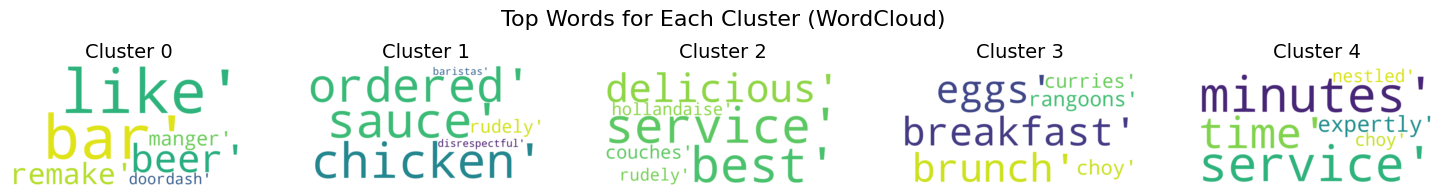

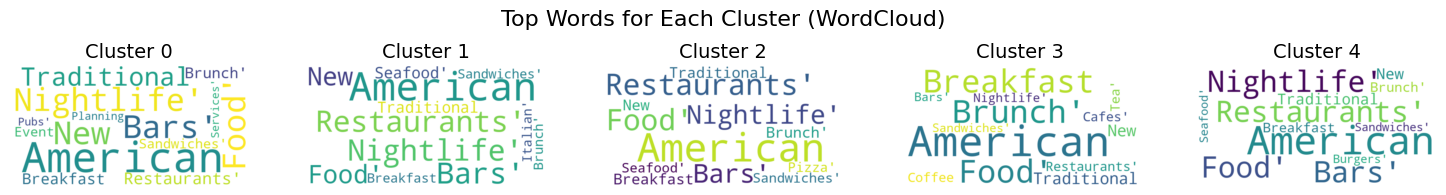

In [83]:
kmeans = KMeans(n_clusters=5, random_state=0, n_init=10, max_iter=500)
cluster_labels = kmeans.fit_predict(svd_data)

cluster_words, cluster_categories = get_top_words_and_categories_per_cluster(tfidf_matrix, cluster_labels, feature_names, n_words=10)
formatted_output = {}

for cluster, categories_list in cluster_categories.items():
    top_categories = [category[0].strip() for category in categories_list[:10]]
    formatted_output[cluster] = [str(top_categories)]
    
plot_top_words_per_cluster_wordcloud(cluster_words)
plot_top_words_per_cluster_wordcloud(formatted_output)

In [84]:
def get_top_words_per_cluster(tfidf_matrix, cluster_labels, feature_names, n_words=10):

    cluster_words = {}

    for cluster in range(max(cluster_labels) + 1):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        cluster_tfidf = tfidf_matrix[cluster_indices].sum(axis=0)
        top_indices = cluster_tfidf.argsort()[0, ::-1][:n_words]
        top_words = [str(feature_names[i]) for i in top_indices]
        cluster_words[cluster] = top_words

    return cluster_words

Cluster 2 start
Cluster 2 finished


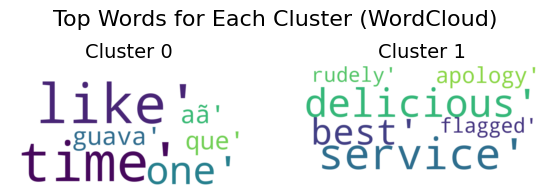

Cluster 3 start
Cluster 3 finished


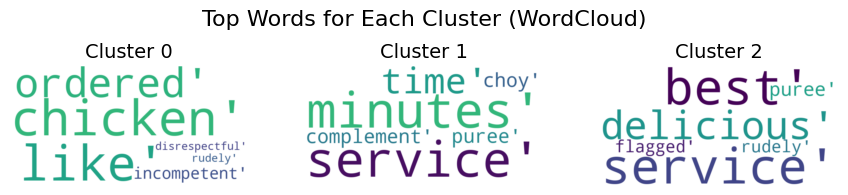

Cluster 4 start
Cluster 4 finished


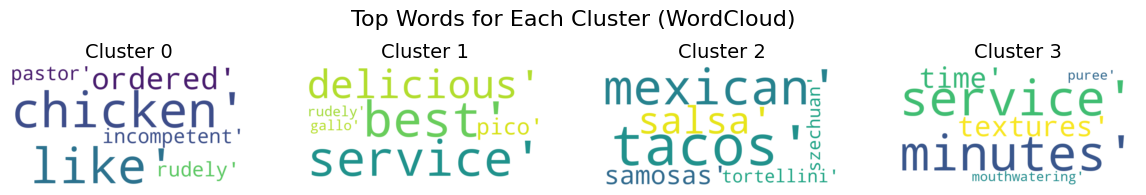

Cluster 5 start
Cluster 5 finished


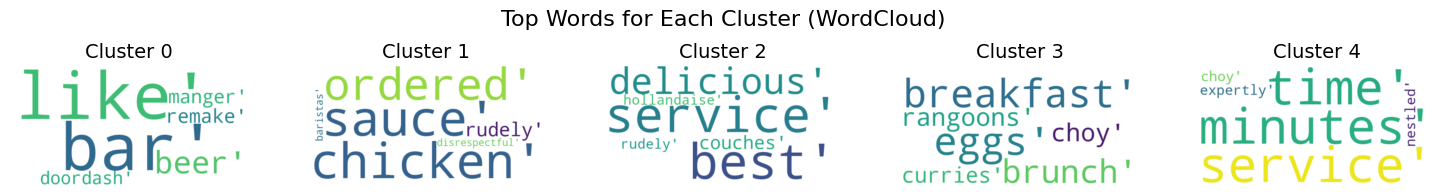

Cluster 6 start
Cluster 6 finished


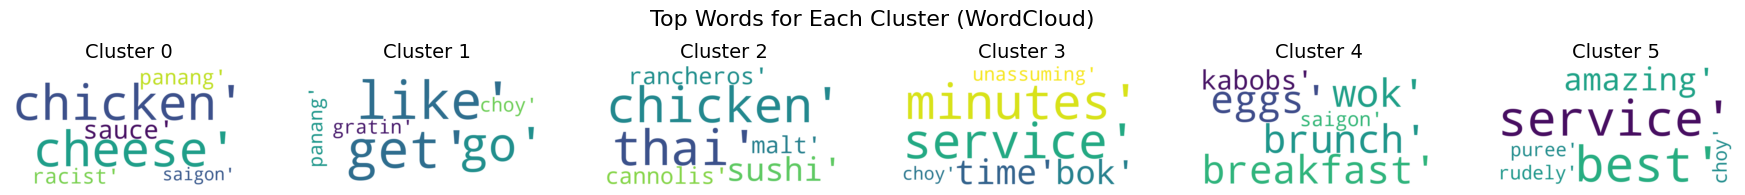

Cluster 7 start
Cluster 7 finished


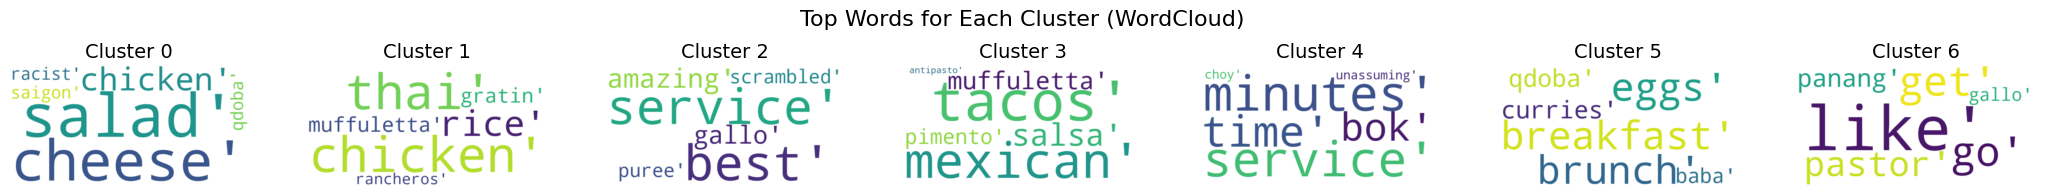

Cluster 8 start
Cluster 8 finished


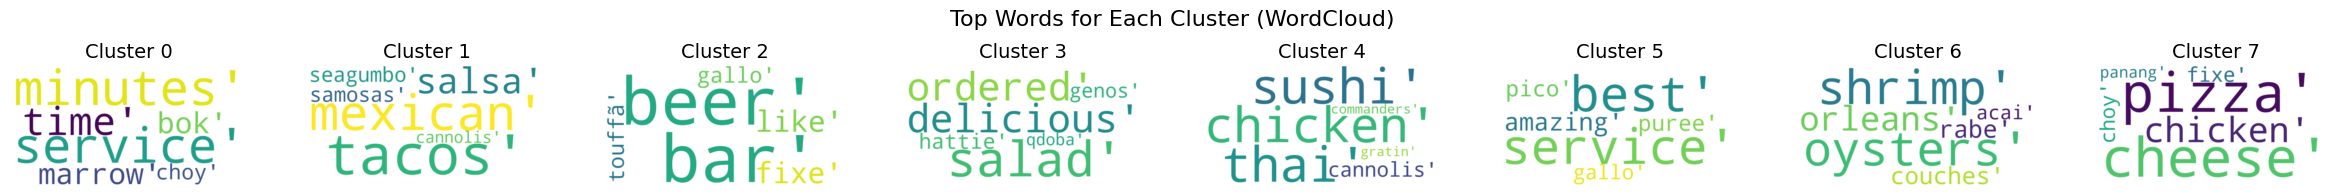

Cluster 9 start
Cluster 9 finished


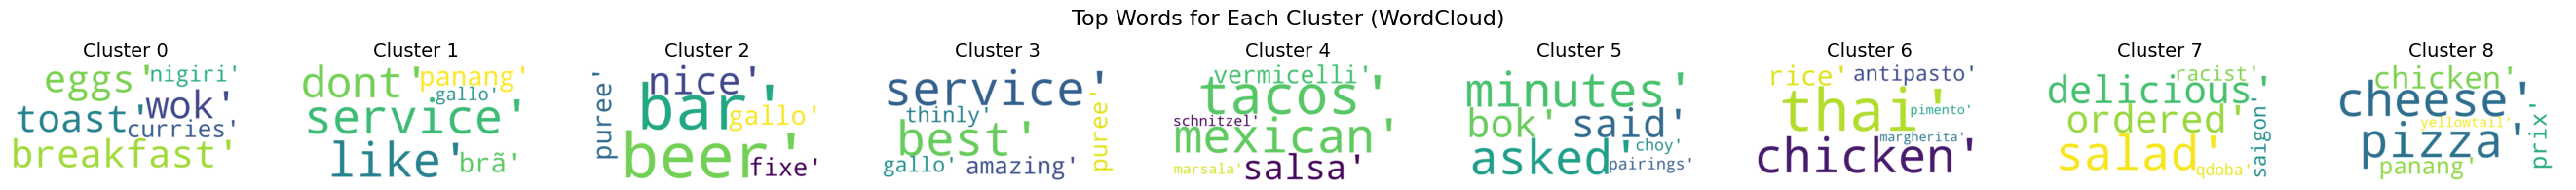

In [85]:
k_values = list(range(2, 10))
silhouette_scores = []

for i, k in enumerate(k_values):
    print(f'Cluster {k} start')

    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10, max_iter=500)
    cluster_labels = kmeans.fit_predict(svd_data)

    print(f'Cluster {k} finished')

    cluster_words=get_top_words_per_cluster(tfidf_matrix, cluster_labels, feature_names)
    plot_top_words_per_cluster_wordcloud(cluster_words)

In [86]:
# time series plot
def get_time_series_plot(k,df):
# k is the number of optimized clusters
  df_cluster=df.copy()
  kmeans = KMeans(n_clusters=k, random_state=0, n_init=10, max_iter=500)
  cluster_labels = kmeans.fit_predict(svd_data)
  df_cluster['cluster']=cluster_labels
  df_cluster['date'] = pd.to_datetime(df_cluster['date'])
  labels=['food_quality','environment','service','convenience','cost_effectiveness']

  # Create a matrix of subplots
  fig, axes = plt.subplots(k, len(labels), figsize=(15, 15), sharex=True, sharey=True)

  for c in range(k):
      # for each cluster, plot the trend for five labels
      # NEED PREPROCESSING OF TIME HERE,use month
      df_cluster['monthly_time']=df_cluster['date'].dt.to_period('M')
      df_cluster['quater_time']=df_cluster['date'].dt.to_period('Q')
      df_cluster=df_cluster.sort_values(by='quater_time')

      for i, label in enumerate(labels):
          # Create a pivot table to get counts for each category and quarter
          pivot_table = df_cluster[df_cluster['cluster'] == c].pivot_table(index='quater_time', columns=label, aggfunc='size', fill_value=0)
          # Calculate percentage distribution
          percentage_distribution = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

          # Plot on the corresponding subplot as stacked bar
          bottom = 0
          for col in percentage_distribution.columns:
              axes[c, i].bar(percentage_distribution.index.astype(str), percentage_distribution[col], label=col, bottom=bottom)
              bottom += percentage_distribution[col]

          axes[c, i].set_title('Cluster ' + str(c + 1) + ': ' + label)
          axes[c, i].legend()

          # Customize x-axis labels
          axes[c, i].tick_params(axis='x', rotation=45, labelsize=7)  # Rotate labels by 45 degrees, set fontsize

          # Set x-axis ticks at the bottom of each plot
          axes[c, i].xaxis.set_ticks_position('bottom')

          # Set x-axis ticks to unique quarter values
          unique_quarters = df_cluster['quater_time'].unique()
          axes[c, i].set_xticks(range(len(unique_quarters)))
          axes[c, i].set_xticklabels(unique_quarters.astype(str))

          # Adjust x-axis ticks based on desired frequency (e.g., every 2 quarters)
          ticks = axes[c, i].get_xticks()
          new_ticks = [ticks[i] for i in range(0, len(ticks), 5)]
          axes[c, i].set_xticks(new_ticks)

  # Set common labels
  for ax in axes.flat:
      ax.set(xlabel='Time', ylabel='Percentage')

  # Adjust layout
  plt.tight_layout()
  plt.show()

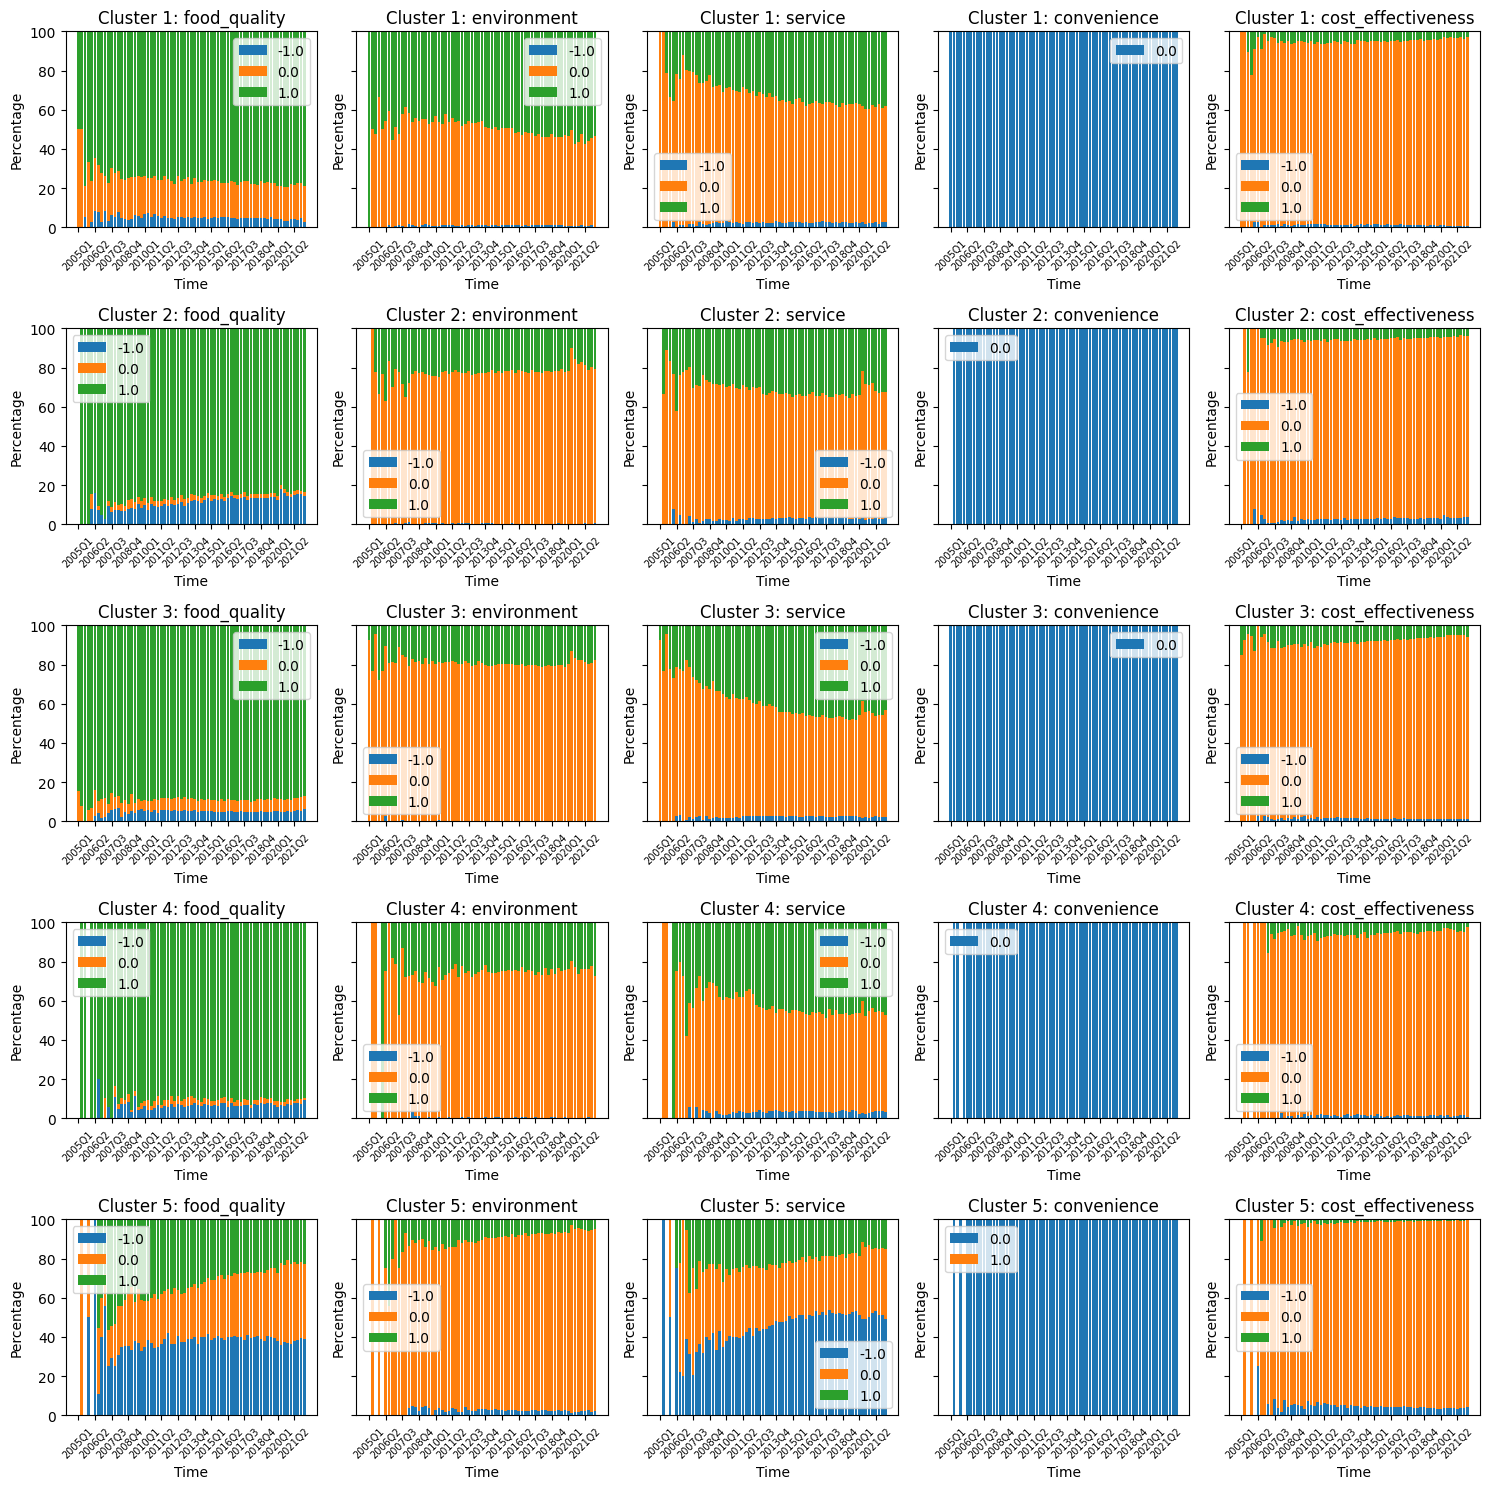

In [87]:
get_time_series_plot(5,filtered_df)